In [1]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

In [2]:
import pandas as pd
from datetime import datetime as dt
from pymongo import MongoClient as mc

mongo_uri = "mongodb://localhost:27017"
client = mc(mongo_uri)
keti_db = client.keti_pattern_recognition

household_col = keti_db.household_info
cluster_col = keti_db.cluster_info
weather_col = keti_db.weather_info

In [38]:
def univariate_data(dataset, start_idx, end_idx, history_size, target_size):
    data = []
    labels = []
    
    start_idx = start_idx + history_size
    if end_idx is None:
        end_idx = len(dataset) - target_size
    
    for i in range(start_idx, end_idx):
        indices = range(i-history_size, i)
        
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    
    return np.array(data), np.array(labels)

array([<AxesSubplot:xlabel='time'>], dtype=object)

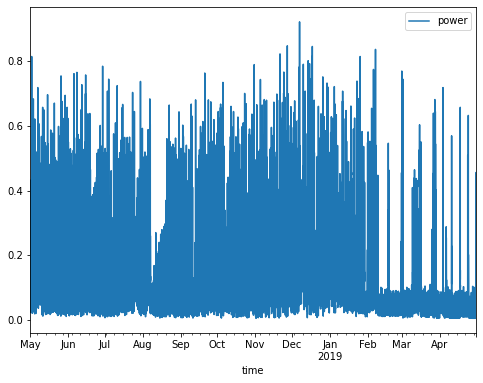

In [33]:
uid = "아파트4-103-106"
hh_db_datas = household_col.find_one({"uid": uid})
hh_db_datas

uid_in, timeslot = hh_db_datas['uid'], hh_db_datas['timeslot']
datas = pd.DataFrame(columns=['power'])
datas['power'] = [ts['power'] for ts in timeslot]
datas.index = [dt.strptime(ts['time'], "%Y-%m-%d T%H:%M %z") for ts in timeslot]
datas.index.name = "time"
datas.head()
datas.plot(subplots=True)

In [34]:
TRAIN_SPLIT = 25000
uni_data = datas.values
uni_data

array([[0.099],
       [0.103],
       [0.084],
       ...,
       [0.038],
       [0.037],
       [0.033]])

In [35]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

uni_data = (uni_data - uni_train_mean) / uni_train_std
uni_data

array([[-0.10674379],
       [-0.06885632],
       [-0.24882183],
       ...,
       [-0.68452779],
       [-0.69399966],
       [-0.73188714]])

In [39]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                          univariate_past_history,
                                          univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                      univariate_past_history,
                                      univariate_future_target)

In [40]:
print("Single window of past history")
print(x_train_uni[0])
print("\nTarget temperature to predict")
print(y_train_uni[0])

Single window of past history
[[-0.10674379]
 [-0.06885632]
 [-0.24882183]
 [-0.29618117]
 [-0.04991258]
 [-0.35301238]
 [-0.44773107]
 [-0.10674379]
 [-0.15410314]
 [-0.4098436 ]
 [-0.32459678]
 [ 0.05427798]
 [-0.15410314]
 [-0.1351594 ]
 [-0.24882183]
 [ 0.0163905 ]
 [-0.22987809]
 [-0.22040622]
 [-0.47614668]
 [-0.1351594 ]]

Target temperature to predict
[-0.10674379]


In [41]:
def create_time_steps(length):
    return list(range(-length, 0))

In [42]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0
        
    plt.title(title)
    for i,x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                    label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

<module 'matplotlib.pyplot' from '/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

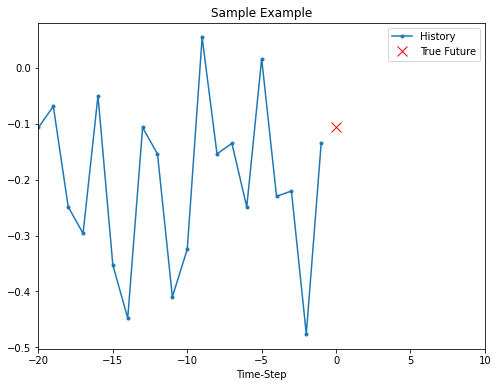

In [43]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [44]:
def baseline(history):
    return np.mean(history)

<module 'matplotlib.pyplot' from '/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

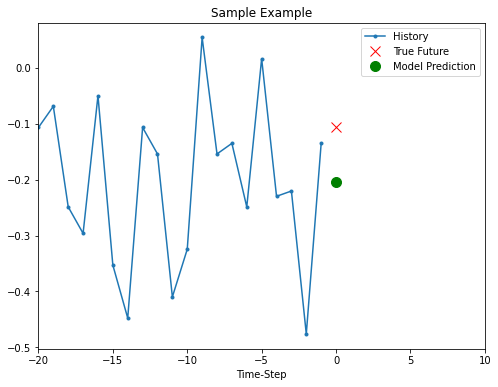

In [45]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0, 'Sample Example')

In [46]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni,
                                                      y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [47]:
x_train_uni.shape[-2:]

(20, 1)

In [48]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')
simple_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8)                 320       
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [49]:
for x,y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


In [52]:
EVALUATION_INTERVAL = 200
EPOCHS = 300

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                     steps_per_epoch=EVALUATION_INTERVAL,
                     validation_data=val_univariate, validation_steps=50)

Epoch 1/300
200/200 [==============================] - 1s 6ms/step - loss: 0.3647 - val_loss: 0.2237
Epoch 2/300
200/200 [==============================] - 1s 6ms/step - loss: 0.3632 - val_loss: 0.2189
Epoch 3/300
200/200 [==============================] - 1s 5ms/step - loss: 0.3614 - val_loss: 0.2219
Epoch 4/300
200/200 [==============================] - 1s 5ms/step - loss: 0.3609 - val_loss: 0.2186
Epoch 5/300
200/200 [==============================] - 1s 5ms/step - loss: 0.3606 - val_loss: 0.2253
Epoch 6/300
200/200 [==============================] - 1s 5ms/step - loss: 0.3593 - val_loss: 0.2261
Epoch 7/300
200/200 [==============================] - 1s 5ms/step - loss: 0.3587 - val_loss: 0.2197
Epoch 8/300
200/200 [==============================] - 1s 5ms/step - loss: 0.3593 - val_loss: 0.2183
Epoch 9/300
200/200 [==============================] - 1s 5ms/step - loss: 0.3592 - val_loss: 0.2247
Epoch 10/300
200/200 [==============================] - 1s 5ms/step - loss: 0.3574 - val_lo

200/200 [==============================] - 1s 5ms/step - loss: 0.3535 - val_loss: 0.2166
Epoch 82/300
200/200 [==============================] - 1s 5ms/step - loss: 0.3519 - val_loss: 0.2129
Epoch 83/300
200/200 [==============================] - 1s 5ms/step - loss: 0.3546 - val_loss: 0.2176
Epoch 84/300
200/200 [==============================] - 1s 6ms/step - loss: 0.3548 - val_loss: 0.2169
Epoch 85/300
200/200 [==============================] - 1s 5ms/step - loss: 0.3526 - val_loss: 0.2159
Epoch 86/300
200/200 [==============================] - 1s 5ms/step - loss: 0.3539 - val_loss: 0.2147
Epoch 87/300
200/200 [==============================] - 1s 5ms/step - loss: 0.3541 - val_loss: 0.2133
Epoch 88/300
200/200 [==============================] - 1s 5ms/step - loss: 0.3549 - val_loss: 0.2142
Epoch 89/300
200/200 [==============================] - 1s 5ms/step - loss: 0.3527 - val_loss: 0.2138
Epoch 90/300
200/200 [==============================] - 1s 5ms/step - loss: 0.3543 - val_loss: 

Epoch 161/300
200/200 [==============================] - 1s 5ms/step - loss: 0.3529 - val_loss: 0.2110
Epoch 162/300
200/200 [==============================] - 1s 5ms/step - loss: 0.3520 - val_loss: 0.2130
Epoch 163/300
200/200 [==============================] - 1s 5ms/step - loss: 0.3524 - val_loss: 0.2117
Epoch 164/300
200/200 [==============================] - 1s 5ms/step - loss: 0.3522 - val_loss: 0.2099
Epoch 165/300
200/200 [==============================] - 1s 5ms/step - loss: 0.3515 - val_loss: 0.2084
Epoch 166/300
200/200 [==============================] - 1s 5ms/step - loss: 0.3525 - val_loss: 0.2089
Epoch 167/300
200/200 [==============================] - 1s 5ms/step - loss: 0.3504 - val_loss: 0.2098
Epoch 168/300
200/200 [==============================] - 1s 5ms/step - loss: 0.3528 - val_loss: 0.2097
Epoch 169/300
200/200 [==============================] - 1s 5ms/step - loss: 0.3519 - val_loss: 0.2131
Epoch 170/300
200/200 [==============================] - 1s 5ms/step - lo

200/200 [==============================] - 1s 5ms/step - loss: 0.3508 - val_loss: 0.2115
Epoch 241/300
200/200 [==============================] - 1s 5ms/step - loss: 0.3502 - val_loss: 0.2122
Epoch 242/300
200/200 [==============================] - 1s 5ms/step - loss: 0.3515 - val_loss: 0.2086
Epoch 243/300
200/200 [==============================] - 1s 5ms/step - loss: 0.3507 - val_loss: 0.2104
Epoch 244/300
200/200 [==============================] - 1s 5ms/step - loss: 0.3507 - val_loss: 0.2100
Epoch 245/300
200/200 [==============================] - 1s 5ms/step - loss: 0.3504 - val_loss: 0.2117
Epoch 246/300
200/200 [==============================] - 1s 5ms/step - loss: 0.3512 - val_loss: 0.2119
Epoch 247/300
200/200 [==============================] - 1s 5ms/step - loss: 0.3497 - val_loss: 0.2078
Epoch 248/300
200/200 [==============================] - 1s 5ms/step - loss: 0.3483 - val_loss: 0.2105
Epoch 249/300
200/200 [==============================] - 1s 5ms/step - loss: 0.3503 - v

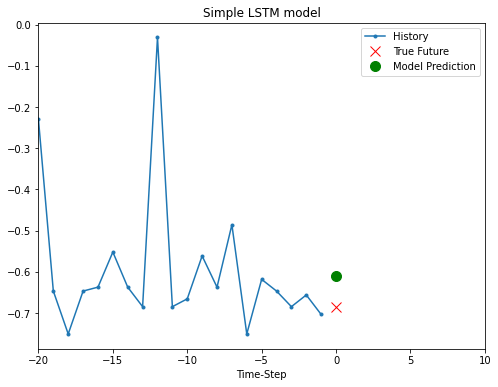

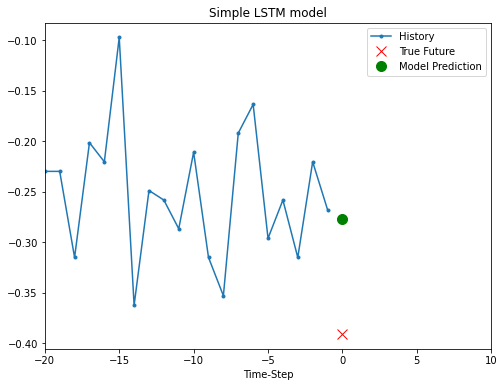

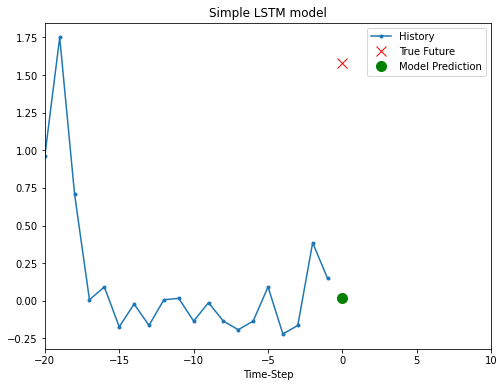

In [53]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                     simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()